### 安裝套件

In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from IPython.display import Image, display
import os
from dotenv import load_dotenv
load_dotenv(override=True)

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

### 建立 State

In [3]:
# State：共享筆記本看目前的狀態
class State(TypedDict):
    # Messages have the type "list". 
    # The `add_messages` function in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


- 每個 Node 都應該取得前一個 state 為 input，並更新 State
- State 將過程中的 messages append 紀錄起來，保留過去所有狀態

### 建立 Node

In [4]:
model = ChatOpenAI(temperature=0.4)
prompt_str = """You are given one question and you have to extract city name from it
Don't respond anything except the city name and don't reply anything if you can't find city name
Only reply the city name if it exists or reply 'no_response' if there is no city name in question

Here is the question:{user_query}
"""
prompt = ChatPromptTemplate.from_template(prompt_str)

chain = prompt | model
res = chain.invoke({"user_query": "請問高雄天氣如何?"})
res.content

def call_model(state: State):
    messages = state["messages"]
    response = chain.invoke(messages)
    return {"messages": [response]}

In [5]:
def get_taiwan_weather(city: str) -> str:
    """查詢台灣特定城市的天氣狀況。"""
    weather_data = {
        "台北": "晴天，溫度28°C",
        "台中": "多雲，溫度26°C",
        "高雄": "陰天，溫度30°C"
    }
    return f"{city}的天氣：{weather_data.get(city)}"

res = get_taiwan_weather(res.content)
res

def weather_tool(state):
  context = state["messages"]
  city_name = context[1].content
  data = get_taiwan_weather(city_name)
  return {"messages": [data]}

In [6]:
def query_classify(state: State):
  messages = state["messages"]
  ctx = messages[-1]
  if ctx.content.startswith("no_response"):
    return "end"
  else:
    return "continue"

In [7]:
model = ChatOpenAI(temperature=0.4)
response_prompt_str = """You have given a weather information and you have to respond to user's query based on the information.
---
Here is the user query: {user_query}
Here is the information: {information}
---
Answer:"""
response_prompt = ChatPromptTemplate.from_template(response_prompt_str)
response_chain = response_prompt | model

def responder(state: State):
    messages = state["messages"]
    response = response_chain.invoke({
        "user_query": messages[0],
        "information": messages[-1]
    })
    return {"messages": [response]}

In [8]:
graph_builder = StateGraph(State)

graph_builder.add_node("agent", call_model)
graph_builder.add_node("weather", weather_tool)
graph_builder.add_node("responder", responder)

graph_builder.add_edge(START, "agent")

# Create an conditional edge
graph_builder.add_conditional_edges('agent', query_classify, {
    "end": "responder",
    "continue": "weather"
})
graph_builder.add_edge("weather", "responder")
graph_builder.add_edge("responder", END)

app = graph_builder.compile()

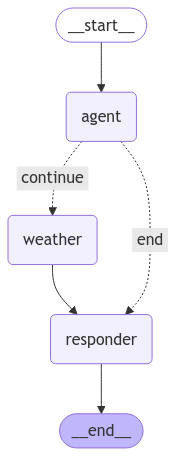

In [9]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [10]:
inputs = {"messages": ["想知道高雄天氣如何？"]}

In [11]:
for output in app.stream(inputs):
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print(value)

Output from node 'agent':
{'messages': [AIMessage(content='高雄', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 3, 'prompt_tokens': 120, 'total_tokens': 123, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-c13b9d95-0a3b-4ce2-acde-a653c0a7aeea-0', usage_metadata={'input_tokens': 120, 'output_tokens': 3, 'total_tokens': 123, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}
Output from node 'weather':
{'messages': ['高雄的天氣：陰天，溫度30°C']}
Output from node 'responder':
{'messages': [AIMessage(content='高雄的天氣是陰天，溫度為30°C。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'pr

In [12]:
inputs = {"messages": ["請問誰是李多慧？"]}
for output in app.stream(inputs):
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print(value)

Output from node 'agent':
{'messages': [AIMessage(content='no_response', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 119, 'total_tokens': 121, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-288f93e7-0e85-4789-95a9-c2fb311ad07e-0', usage_metadata={'input_tokens': 119, 'output_tokens': 2, 'total_tokens': 121, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}
Output from node 'responder':
{'messages': [AIMessage(content='抱歉，根據提供的信息，我無法回答關於李多慧的問題。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 311, 'total_tokens': 346, 'comp